In [35]:
# This python notebook is used for analysis and learning the different network blocks used in VIT (Vision Transformers), and also blocks specific to Hformer

# Reference implementation (that uses pytorch) : https://www.youtube.com/watch?v=j3VNqtJUoz0

# Reference for VIT impl : https://dzlab.github.io/notebooks/tensorflow/vision/classification/2021/10/01/vision_transformer.html

In [1]:
import sys
sys.path.append('../')

import tensorflow as tf
from data_importer import load_training_images
import numpy as np
import matplotlib.pyplot as plt

c:\Users\Tarun\miniconda3\envs\denoising-conda-env\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Visualizing the image pairs

loaded training images x and y of len :  2 2  respectively
type of train images x :  float64
range of values in train images :  0.0 0.9804736186123806
type of train images y :  float64
shape of x_data and y_data :  (2, 512, 512, 1) (2, 512, 512, 1)


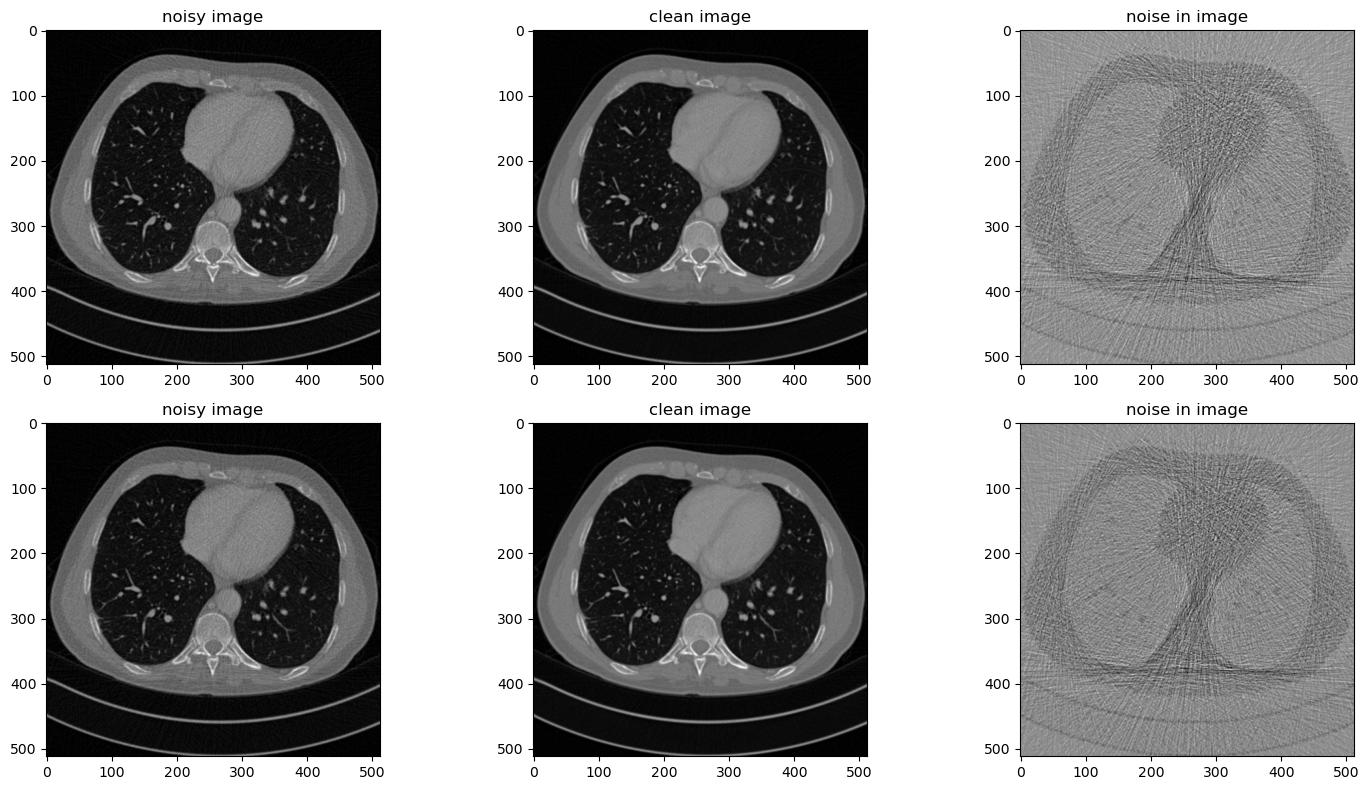

In [4]:
x_data, y_data = load_training_images('../../../../../Dataset/LowDoseCTGrandChallenge/Training_Image_Data/', True, 2)

print('shape of x_data and y_data : ', x_data.shape, y_data.shape)

f, ax = plt.subplots(len(x_data), 3, figsize=(15,8))

for i in range(len(x_data)):
    
    ax[i,0].set_title('noisy image')
    ax[i,0].imshow(x_data[i], cmap='gray')
    
    ax[i,1].set_title('clean image')
    ax[i,1].imshow(y_data[i], cmap='gray')
    
    ax[i,2].set_title('noise in image')
    ax[i,2].imshow(x_data[i] - y_data[i], cmap='gray')
    
    plt.plot()
    
plt.tight_layout()
plt.show()

Patch Extractor (Custom function)

In [5]:
# The goal of this function is to take a image as input and split it into 2D patches of given dimension.
# Note that the image dimensions must be such that patches (of same dimension) should completely cover the image.
# Returns a array of patches (in row format order)
def create_patches_from_image(image, patch_width, patch_height):
    image = image.copy()
    
    image_height, image_width, image_depth = image.shape
    if image_height % patch_height != 0 or image_width % patch_width != 0:
        print('cannot create patches of width and height : ', patch_width ,patch_height, ' for image as dimension of patches does not exactly divide image completely')

        return
    
    # Reshape the image array into 3D array where each slice represents a patch    
    # The image originally has dimension of image_width, image_height, image_depth.
    # The new shape (of patches) is num_patches_vertically, patch_height, num_patches_horizontally, patch_width, image_depth.
    patches = image.reshape(image_height // patch_height, patch_height, image_width // patch_width, patch_width, image_depth)
    
    print('shape of patches after reshaping to dimensions (num_patches_vertically, patch_height, num_patches_horizontally, patch_width, image_depth) : ', patches.shape)
    
    # Swapaxes is used to rearrange dimensions and that reshape is applied to flatten the array.
    # The swapaxes is done to swap 2nd and third dimension so that patches are grouped by horizontal order 
    # The shape is now in order : (num_patches_vertically, num_patches_horizontally, patch_height, patch_width, image_depth)
    patches = patches.swapaxes(1, 2)
    print('shape of patches after swapping axes : ', patches.shape)
    
    # Reshape is done to convert the 5D array into a 4D array of shape : (number_of_patches_flattened, patch_height, patch_width, image_depth)
    patches = patches.reshape(-1, patch_height, patch_width, image_depth)
    
    return patches

In [6]:
patches = create_patches_from_image(x_data[0], 32, 32)

print('shape of patches (resultant of the create_patches_from_image function) : ', patches.shape)

shape of patches after reshaping to dimensions (num_patches_vertically, patch_height, num_patches_horizontally, patch_width, image_depth) :  (16, 32, 16, 32, 1)
shape of patches after swapping axes :  (16, 16, 32, 32, 1)
shape of patches (resultant of the create_patches_from_image function) :  (256, 32, 32, 1)


In [7]:
def display_patches_in_grid(patches, grid_size):
    num_patches, patch_height, patch_width, image_depth = patches.shape
    
    plt.figure(figsize=(4,4))

    for i in range(min(num_patches, grid_size * grid_size)):
        plt.subplot(grid_size, grid_size, i + 1)
        plt.imshow(patches[i], cmap='gray', vmin=0, vmax=1)
        plt.axis('off')

    plt.tight_layout(pad=0.1)
    plt.show()

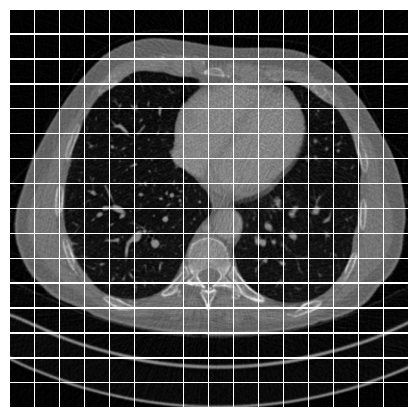

original image


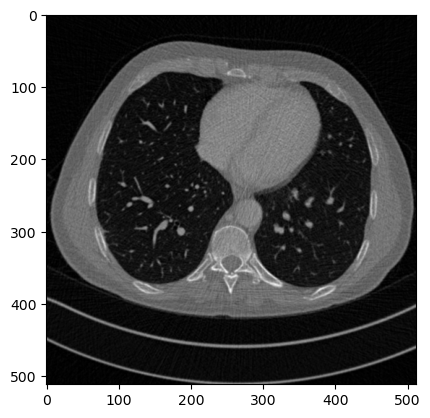

In [8]:
display_patches_in_grid(patches, 16) # 16 is number of parches vertically and horizontally. Should be equal to number of patches the image was split into
print('original image')
plt.imshow(x_data[0],cmap='gray', vmin=0, vmax=1)

Patch extractor (Using TF for efficiency)

In [48]:
# For sake of efficiency, tf.image has functions that will extract patches from images.
# Creating a custom layer for ease of use when creating the model.
# https://dzlab.github.io/notebooks/tensorflow/vision/classification/2021/10/01/vision_transformer.html


# Takes as input patch_size, which will be same along width and height
# As hformer uses overlapping slices to increase number of training samples, set the stride to a values less than patch_size.

# NOTE : The output shape is num_patches, patch_height, patch_width, patch_depth.
# The Fig1 of paper mentions input to input projection layer is 1 X H X W. Output of this layer is H X W X 1

class PatchExtractor(tf.keras.layers.Layer):
    def __init__(self, patch_size, stride):
        super(PatchExtractor, self).__init__()
        self.patch_size = patch_size
        self.stride = stride

    def call(self, images):
        # batch_size : number of images, which is not used.
        batch_size = tf.shape(images)[0] 
        # Expected to always be 1.
        patch_depth = images.shape[-1]
        
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.stride, self.stride, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patches = tf.reshape(patches, [-1, self.patch_size, self.patch_size, patch_depth])
        return patches

In [49]:
patches = PatchExtractor(patch_size=64, stride=64)(x_data)
print('shape of patches : num_patches, patch_height, patch_width, num_channels : ', patches.shape)

shape of patches : num_patches, patch_height, patch_width, num_channels :  (128, 64, 64, 1)


In [50]:
# Example of what happens when stride is set to 1 (to get overlapping slices)
overlapping_patches = PatchExtractor(patch_size=64, stride=16)(x_data)
print('shape of patches : num_patches, patch_height, patch_width, num_channels : ', overlapping_patches.shape)

shape of patches : num_patches, patch_height, patch_width, num_channels :  (1682, 64, 64, 1)


Patch Extractor Visualization

patches per image :  64
this image has start patches :  0


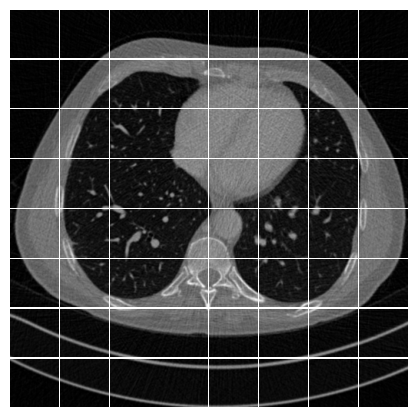

this image has start patches :  64


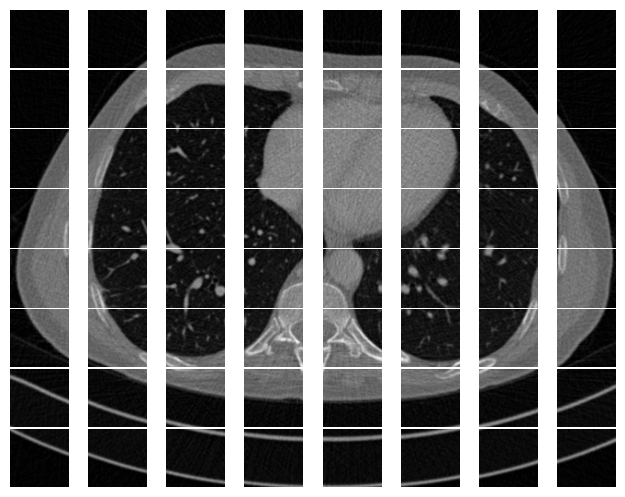

In [51]:
num_images = len(x_data)
num_patches_per_image = int(patches.shape[0] / len(x_data))

print('patches per image : ', num_patches_per_image)

plt.figure(figsize=(4, 4))

for i in range(num_images):
    print('this image has start patches : ', i * num_patches_per_image)
    image_patches = patches[i * num_patches_per_image:i * num_patches_per_image + num_patches_per_image]
        
    for j, patch in enumerate(image_patches):
        plt.subplot(int(np.sqrt(num_patches_per_image)), int(np.sqrt(num_patches_per_image)), j + 1)
        plt.imshow(patch.numpy(), cmap='gray', vmin=0, vmax=1)
        plt.axis('off')

    plt.tight_layout(pad=0.1)
    plt.show()


Input Projection Layer

In [52]:
# NOTE : The paper does not mention what constitutes the input projection block.
# The ONLY thing mentioned in input is each image patch (that is 64x64). Input to the input projection block is 1 X H X W, and output is C X H X W

# NOTE (ASSUMPTIONS) : The input 'projection' block uses convolution (3x3) and C is the number of kernels.
# I chose 3x3 since the paper does not say what H, W is, and C is assumed to be 64 (not mentioned in paper again)

# num_kernels = C in the block diagram. NO activation function is used (assumed linear).
class InputProjectionLayer(tf.keras.layers.Layer):
    def __init__(self, num_kernels, kernel_size=(3, 3), **kwargs):
        super(InputProjectionLayer, self).__init__(**kwargs)
        self.num_kernels = num_kernels
        self.kernel_size = kernel_size

        # Define the convolutional layer
        self.convolution = tf.keras.layers.Conv2D(filters=num_kernels,
                                                  kernel_size=kernel_size,
                                                  padding='same')

    def call(self, inputs):
        output = self.convolution(inputs)
        return output

In [68]:
print('input shape to input projection layer : ', patches.shape)

output = InputProjectionLayer(num_kernels=64, kernel_size=(3,3))(patches)
print('shape of input projection layer output : ', output.shape)

input_projection_output = output

input shape to input projection layer :  (128, 64, 64, 1)
shape of input projection layer output :  (128, 64, 64, 64)


Output projection layer

In [54]:
# NOTE : The paper does not mention what constitutes the output projection block.
# The ONLY thing mentioned in input is of shape C X H X W and output is 1 X H X W

# NOTE (ASSUMPTIONS) : The output 'projection' block uses transposed convolution (3x3) and C is the value of C (num_features_maps).

# NO activation function is used (assumed linear).
# kernel_size must MATCH whatever was given to InputProjectionLayer
class OutputProjectionLayer(tf.keras.layers.Layer):
    def __init__(self, kernel_size=(3, 3), **kwargs):
        super(OutputProjectionLayer, self).__init__(**kwargs)

        # Define the deconvolutional layer
        self.deconvolution = tf.keras.layers.Conv2DTranspose(filters=1,
                                                             kernel_size=kernel_size,
                                                             padding='same',
                                                             activation='relu')

    def call(self, inputs):
        output = self.deconvolution(inputs)
        return output


In [69]:
print('input shape to output projection layer : ', output.shape)

output = OutputProjectionLayer(kernel_size=(3,3))(output)
print('shape of output projection layer output : ', output.shape)


input shape to output projection layer :  (128, 64, 64, 64)
shape of output projection layer output :  (128, 64, 64, 1)


Convolution Block (i.e ConvNet block)

In [45]:
# A CNN is used since it captures local features better than transformers (which capture global features better). Also, a CNN has translational invariance unlike transformers.

# HFormer uses depth separable convolutions.
# DWC has fewer number of learnable parameters compared to regular CNN.
# It applies 1 kernel to each channel of input feature map, and combines the output of all kernels to obtain final result.
# The number of output channels for convolutional operation = number of kernels, and only 1 kernel is used per channel.
# So, the number of output channels for single channel = 1.

# In HFormer, 2 depth separable convolutional layers were used to improve local representation. Also, LN (Layer normalization) and GELU (Gaussian error linear unit) were used to introduce non linear feature mapping.
# Skip connections are also used for residual learning.
# NOTE : linear here is linear projection convolution.

![](../../images/hformer-cnn.png)

In [101]:
# Custom tf layer for convolutional block.

# Official / Unofficial documentation for the constituent layers / blocks:
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/DepthwiseConv2D
# https://github.com/dongkyuk/ConvNext-tensorflow/blob/main/model/convnext.py
# https://keras.io/examples/vision/edsr/
# https://github.com/martinsbruveris/tensorflow-image-models/blob/d5f54175fb91e587eb4d2acf81bb0a7eb4424f4a/tfimm/architectures/convnext.py#L146

# io_num_channels : Number of channels per image / patch for input and output.
class ConvolutionBlock(tf.keras.layers.Layer):
    def __init__(self, io_num_channels):
        super(ConvolutionBlock, self).__init__()
        self.layers = tf.keras.Sequential([
            # Layer 0 : Padding to ensure that the output size is same as input size.
            # Padding is done by 3 because the DWConv will always be 7x7
            tf.keras.layers.ZeroPadding2D(padding=3, name="ConvBlock zero padding 2d"),
            
            # Layer 1 : Depth wise convolution (7x7)
            tf.keras.layers.DepthwiseConv2D(7, depth_multiplier=1, name="ConvBlock depthwise conv 2d"),
            
            # Layer 2 : Layer normalization
            tf.keras.layers.LayerNormalization(name="ConvBlock layer normalization"),
        
            # Layer 3 : Linear (1)
            tf.keras.layers.Conv2D(1, kernel_size=1, name="ConvBlock linear 1x1 (first) conv 2d"),
            
            # Layer 4 : GELU activation
            tf.keras.layers.Activation('gelu', name="ConvBlock GELU activation"),
            
            # Layer 5 : Linear (2)
            tf.keras.layers.Conv2D(io_num_channels, kernel_size=1, name="ConvBlock linear 1x1 (second) conv2d"),
        ])
        
    def call(self, images):
        print('[Conv block] input : ', images.shape)
        
        # Here, assuming that images are of the shape (num_images, image_height, image_width, num_channels)
        output = self.layers(images)
        
        # Extract the number of channels from the input feature map
        num_channels = images.shape[-1]
                
        # Added the residual / skip connection
        residual = images
        
        output = tf.concat([output, residual], axis=0)

        print('[Conv block] output : ', output.shape)

        return output        

[Conv block] input :  (128, 64, 64, 1)
[Conv block] output :  (256, 64, 64, 1)


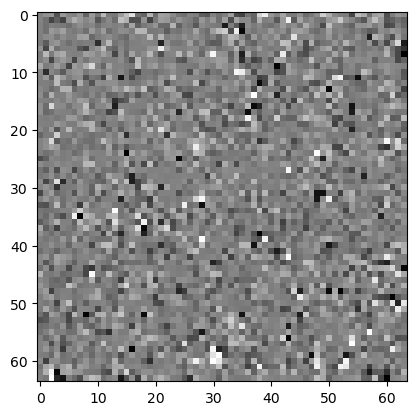

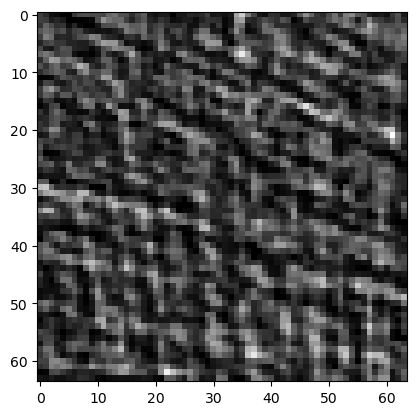

In [103]:
# Test of convolutional block

output = ConvolutionBlock(io_num_channels=patches.shape[-1])(patches)


# Visualizion of the output of the convolution block
plt.imshow(output[0], cmap='gray')
plt.show()

plt.imshow(patches[0], cmap='gray')

In [104]:
# Test of convolutional block (with input as input projection's output)

output = ConvolutionBlock(io_num_channels=input_projection_output.shape[-1])(input_projection_output)
print('output.shape : ', output.shape)

[Conv block] input :  (128, 64, 64, 64)
[Conv block] output :  (256, 64, 64, 64)
output.shape :  (256, 64, 64, 64)


In [52]:
# Implementation of HFormer block

![]('../../../../images/hformer-block.png)

In [100]:
# Note  : Max pooling kernel size is taken as value for stride in the max pooling layer.
# This is because we want NO overlaps between the 'pools' used in maxpooling.

# NOTE : depth_wise_conv_kernel_size will always be 7x7.
# NOTE : Max pool kernel size is basically 'k' from the diagram
# Attention scaling factor depends on the network depth. It is the (1 / sqrt(dk)) that is mentioned in the paper.
# num_channels = (C in the diagram)
class HformerBlock(tf.keras.layers.Layer):
    def __init__(self, maxpool_kernel_size, attention_scaling_factor, num_channels, **kwargs):
        super(HformerBlock, self).__init__(**kwargs)

        # Saving the layer input parameters.
        self.k = maxpool_kernel_size
        self.dk = attention_scaling_factor
        self.c = num_channels

        # Defining the layers required by the HformerBlock.

        # Layers for path A (i.e DWConv, Norm, Linear, Gelu, Linear)        
     
        # Depth wise conv (i.e applying a separate filter for each image channel)
        self.depthwise_conv = tf.keras.layers.DepthwiseConv2D(
            (7, 7),
            strides=(1, 1),
            padding='same',
            use_bias=False,
            name="Hformer depth wise conv")
    
        # Defining the layers for path B (i.e max pooling, self attention, linear)

        # Max pooling layers (will be used in attention computation for Keys and Queries)
        self.maxpool = tf.keras.layers.MaxPooling2D((maxpool_kernel_size, maxpool_kernel_size), strides=(maxpool_kernel_size, maxpool_kernel_size), name="Hformer max pooling layer")

        # Create variables based on dynamically determined C 
        # (Q, K, V) are used for attention.
        # This is clear from the paper which mentions :
        # The (original) self-attentive mechanism first generates the corresponding query e
        # (q), Key (K) and Value (V)
        # The output of K and Q linear are : HW/k^2 X C
        
        self.k_linear = tf.keras.layers.Dense(self.C, use_bias=False, name="Hformer k linear")
        self.q_linear = tf.keras.layers.Dense(self.C, use_bias=False, name="Hformer q linear")
        
        self.v_linear = tf.keras.layers.Dense(self.C, use_bias=False, name="Hformer v linear")

        # Defining the layers for the stage where input is output of path A and path B
        
        self.norm = tf.keras.layers.LayerNormalization(name="Hformer layer normalization")        
        self.linear_1 = tf.keras.layers.Conv2D(1, kernel_size=1, name="Hformer linear 1x1 conv2d (first)")
        self.gelu = tf.keras.layers.Activation('gelu', name="Hformer gelu activation")
        self.linear_2 = tf.keras.layers.Conv2D(num_channels, kernel_size=1, name="Hformer linear 1x1 conv2d (second)")

    def call(self, images):
        # NOTE : The shape of images MUST be num_images, image_height, image_width, num_channels (which is already set in the constructor)
        
        # In the Hformer block, the input takes 2 paths.
        # In path A, images undergoe depth wise convolution (DWConv based perceptual module)
        # In path B, images undergoe a transformer module with lightweight self attention module (i.e self attention after maxpooling)
        
        # Code for path A.
        path_a_output = self.depthwise_conv(images)
        
        print('depth wise conv output shape : ', path_a_output.shape)
        
        # Code for path B.
        max_pooled_images = self.maxpool(images)
                    
        print('shape after max pooling : ', max_pooled_images.shape)
        
        # Attention module computation.
        # Q, K, V all pass through linear layers. 
        # q and k are reshaped into HW / (max pool kernel size)^2 X C
        print('input shape expected by q_linear, k_linear and v_linear : ', self.C)
        
        q = self.q_linear(max_pooled_images)
        print('shape of q after applyling q_linear : ', q.shape)
        q = tf.reshape(q, (-1, self.C, max_pooled_images.shape[1] * max_pooled_images.shape[2]))
        print('shape of q after reshaping  : ', q.shape)
        
        k = self.k_linear(max_pooled_images)
        k = tf.reshape(k, (-1, self.C, max_pooled_images.shape[1] *  max_pooled_images.shape[2]))

        print('q and k shape : ', k.shape)
        
        v = self.v_linear(images)
        v = tf.reshape(v, (-1, self.C, images.shape[1] * images.shape[2]))
        
        print('shape of v :', v.shape)

        # Computation of attention
        # attention = ((K'T Q) / sqrt(dk)) V
        attention = tf.matmul(q, k, transpose_b=True)
        print('q * k shape : ', attention.shape)
        
        # As per paper, after performing softmax, we obtain a attention score matrix with dimension C x C.
        # The scaling factor mentioned in the paper (i.e 1/sqrt(dk)) is based on network depth.
        attention = tf.nn.softmax(attention / tf.sqrt(tf.cast(self.dk, tf.float32)))

        # Now, the final attention map is obtained by multiplied v and attention.
        attention = tf.matmul(attention, v)
        
        print ('final attention shape : ', attention.shape)
        
        # Now, attention is reshaped into the same dimensions as the input image.
        path_b_output = tf.reshape(attention, (-1, path_a_output.shape[1], path_a_output.shape[2], path_a_output.shape[3]))
        
        print('path b output shape : ', path_b_output.shape)
        
        combined_path_output = tf.concat([path_a_output, path_b_output], axis=-1) 
        
        print('combined path output shape : ', combined_path_output.shape)
            
        x = combined_path_output
        x = self.norm(x)
        
        print('shape after layer normalization : ', x.shape)
        x = self.linear(x)
        print('shape after hformer block linear 1 : ', x.shape)
        x = self.gelu(x)
        print('shape after hformer block gelu : ', x.shape)
        #x = self.linear(x)
        
        print('final output shape : ', x.shape)
        
        return x

depth wise conv output shape :  (2, 512, 512, 1)
shape after max pooling :  (2, 256, 256, 1)
input shape expected by q_linear, k_linear and v_linear :  1
shape of q after applyling q_linear :  (2, 256, 256, 1)
shape of q after reshaping  :  (2, 1, 65536)
q and k shape :  (2, 1, 65536)
shape of v : (2, 1, 262144)
q * k shape :  (2, 1, 1)
final attention shape :  (2, 1, 262144)
path b output shape :  (2, 512, 512, 1)
combined path output shape :  (2, 512, 512, 2)
shape after layer normalization :  (2, 512, 512, 2)
shape after hformer block linear 1 :  (2, 512, 512, 1)
shape after hformer block gelu :  (2, 512, 512, 1)
final output shape :  (2, 512, 512, 1)
shape of input :  (2, 512, 512, 1)
shape of output :  (2, 512, 512, 1)


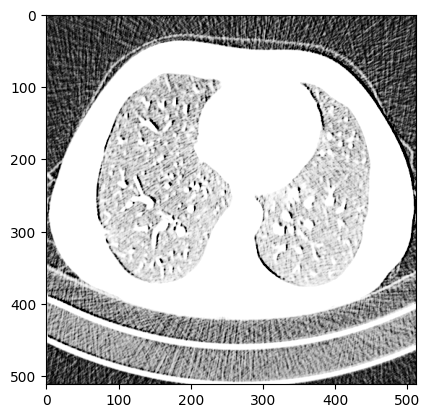

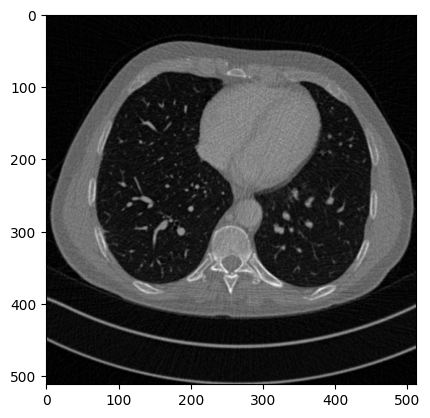

In [82]:
# Testing of Hformer block

output = HformerBlock(depth_wise_conv_kernel_size=7, maxpool_kernel_size=2, attention_scaling_factor=1, num_feature_maps=1)(x_data)

print('shape of input : ', x_data.shape)
print('shape of output : ', output.shape)

# Visualizion of the output of the convolution block
plt.imshow(output[0], cmap='gray', vmin=0, vmax=1)
plt.show()

plt.imshow(x_data[0], cmap='gray')

In [ ]:
# Implementation of the entire architecture of Hformer

![](../../images/hformer-architecture.png)

In [77]:
# Documentation of subclassing API : https://www.tensorflow.org/guide/keras/making_new_layers_and_models_via_subclassing

# Note : Assumes x and y data are already split into image patches (overlapping or non overlapping)
class Hformer(tf.keras.Model):
    def __init__(self):
        super().__init__()
        
        # While this is here, the model takes as input the image patches.
        # A slight deviation to the original architecture
        self.patch_extraction = PatchExtractor(patch_size=32, stride=32)
        
        self.conv_net_block = ConvolutionBlock()
        
        # As per the paper, 2x2 conv layers are used for both upsampling and downsampling.
        self.down_sampling_layer = tf.keras.layers.Conv2D(1, (2,2), (2,2))
        
        # Conv2D transpose : Deconv layer
        self.up_sampling_layer = tf.keras.layers.Conv2DTranspose(1, (2, 2), (2, 2))
                
    def call(self, images):
        input_image_shape = images.shape
        
        print('shape of input images : ', images.shape)
        
        # Split image into patches
        # image_patches = self.patch_extraction(images)
        # The model assumes this has been done already.
        image_patches = images
        
        print('size of image patches : ', image_patches.shape)
        
        # First conv block filtering
        conv_block_1_output = self.conv_net_block(image_patches)
        
        print('shape after conv block : ', conv_block_1_output.shape)
        
        # Downsampling images from (C X H X W) to (2C X H/2 X W/2)
        x = self.down_sampling_layer(conv_block_1_output)
        
        print('hformer input shape : ', x.shape)
        
        # Hformer block application
        hformer_block_1_output = HformerBlock(depth_wise_conv_kernel_size=7, maxpool_kernel_size=2, attention_scaling_factor=1, num_feature_maps=x.shape[0])(x)

        # Downsampling imagesm from (2C X H/2 X W/2) to (4C X H/4 X W/4)
        x = self.down_sampling_layer(hformer_block_1_output)
        
        print('shape after downsampling : ', x.shape)
        
        x = HformerBlock(depth_wise_conv_kernel_size=7, maxpool_kernel_size=2, attention_scaling_factor=1, num_feature_maps=x.shape[0])(x)
        
        # Upsampling block 1
        x = self.up_sampling_layer(x)
        
        # Hformer block application and skip connection.
        x = HformerBlock(depth_wise_conv_kernel_size=7, maxpool_kernel_size=2, attention_scaling_factor=1, num_feature_maps=x.shape[0])(x)
        
        x = tf.concat([x, hformer_block_1_output], axis=-1) 

        
        # Upsampling image to 2C X H/2 X W/2
        x = self.up_sampling_layer(x)
        
        # Conv block filtering + skip connection.
        x = self.conv_net_block(x)
        
        x = tf.concat([x, conv_block_1_output], axis=-1) 
        
        print('hformer model output shape : ', x.shape)
        return x
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "C": self.C
        })
        return config

    @classmethod
    def from_config(cls, config):
        layer = cls(**config)
        layer.build(input_shape=config["input_shape"])
        return layer

In [78]:
model = Hformer()
output = model.call(PatchExtractor(patch_size=64, stride=64)(x_data))

shape of input images :  (128, 64, 64, 1)
size of image patches :  (128, 64, 64, 1)
[Conv block] input :  (128, 64, 64, 1)
[Conv block] output :  (128, 64, 64, 1)
shape after conv block :  (128, 64, 64, 1)
hformer input shape :  (128, 32, 32, 1)
depth wise conv output shape :  (128, 32, 32, 1)
shape after max pooling :  (128, 16, 16, 1)
input shape expected by q_linear, k_linear and v_linear :  128
shape of q after applyling q_linear :  (128, 16, 16, 128)
shape of q after reshaping  :  (128, 128, 256)
q and k shape :  (128, 128, 256)
shape of v : (128, 128, 1024)
q * k shape :  (128, 128, 128)
final attention shape :  (128, 128, 1024)
path b output shape :  (16384, 32, 32, 1)


InvalidArgumentError: Exception encountered when calling layer 'hformer_block_21' (type HformerBlock).

{{function_node __wrapped__ConcatV2_N_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} ConcatOp : Dimension 0 in both shapes must be equal: shape[0] = [128,32,32,1] vs. shape[1] = [16384,32,32,1] [Op:ConcatV2] name: concat

Call arguments received by layer 'hformer_block_21' (type HformerBlock):
  • images=tf.Tensor(shape=(128, 32, 32, 1), dtype=float32)

In [ ]:
# Visualing output of the hformer model.
def visualize_patches(patches):
  # Visualize these patches
  batch_size = len(x_data)
  num_patches_per_image = int(patches.shape[0] / len(x_data))

  print('patches per image : ', num_patches_per_image)

  plt.figure(figsize=(4, 4))

  for i in range(batch_size):
    print('image number : ', i)
    plt.figure(figsize=(4, 4))

    print('this image has start patches : ', i * num_patches_per_image)
    image_patches = patches[i * num_patches_per_image:i * num_patches_per_image + num_patches_per_image]

    for j, patch in enumerate(image_patches):
      plt.subplot(16, 16, j + 1)
      plt.imshow(patch.numpy(), cmap='gray', vmin=0, vmax=1)
      plt.axis('off')

    plt.tight_layout(pad=0.1)
    plt.show()
    plt.tight_layout(pad=0.1)
    plt.figure(figsize=(4, 4))



patches per image :  256
image number :  0
this image has start patches :  0


<Figure size 400x400 with 0 Axes>

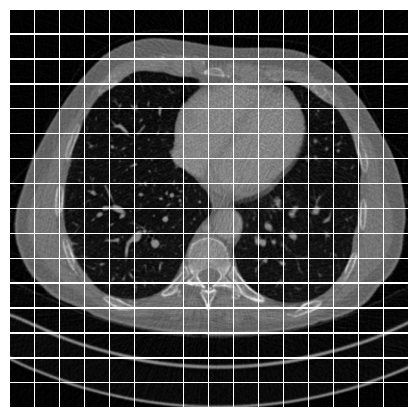

image number :  1
this image has start patches :  256


<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

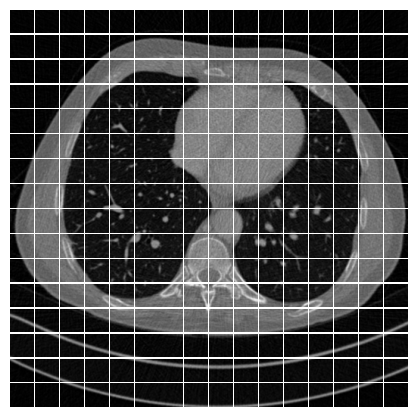

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

In [ ]:
visualize_patches(patches)

In [ ]:
# Testing if model can be compiled
# From the paper,
# The batch size is 16 through 4000 epochs. 
# The ADAM-W optimizer was used to minimize the mean squared error loss, and the learning rate was 1.0 × 10−5
patch_extractor = PatchExtractor(patch_size=32, stride=32)
model.build(patch_extractor(x_data).shape) 
model.compile(tf.optimizers.Adam(learning_rate=1.0 * 10**-5), metrics='accuracy', loss='mse', batch_size=16)


shape of input images :  (512, 32, 32, 1)
size of image patches :  (512, 32, 32, 1)
[Conv block] input :  (512, 32, 32, 1)
[Conv block] output :  (512, 32, 32, 1)
shape after conv block :  (512, 32, 32, 1)
hformer input shape :  (512, 16, 16, 1)
depth wise conv output shape :  (512, 16, 16, 1)
shape after max pooling :  (512, 8, 8, 1)
input shape expected by q_linear, k_linear and v_linear :  512
shape of q after applyling q_linear :  (512, 8, 8, 512)
shape of q after reshaping  :  (512, 512, 64)
q and k shape :  (512, 512, 64)
shape of v : (512, 512, 256)
q * k shape :  (512, 512, 512)
final attention shape :  (512, 512, 256)
path b output shape :  (262144, 16, 16, 1)
combined path output shape :  (262656, 16, 16, 1)
shape after hformer block linear 1 :  (262656, 16, 16, 1)
shape after hformer block gelu :  (262656, 16, 16, 1)
shape after downsampling :  (262656, 8, 8, 1)
depth wise conv output shape :  (262656, 8, 8, 1)
shape after max pooling :  (262656, 4, 4, 1)
input shape expect

StagingError: Exception encountered when calling layer 'hformer_block_1' (type HformerBlock).

in user code:

    File "C:\Users\Tarun\AppData\Local\Temp\ipykernel_13772\958413466.py", line 105, in call  *
        x = self.norm(x)
    File "C:\Users\Tarun\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler  **
        raise e.with_traceback(filtered_tb) from None

    OverflowError: Exception encountered when calling layer 'layer_normalization_1' (type LayerNormalization).
    
    Python int too large to convert to C long
    
    Call arguments received by layer 'layer_normalization_1' (type LayerNormalization):
      • inputs=tf.Tensor(shape=(68988436992, 8, 8, 1), dtype=float32)


Call arguments received by layer 'hformer_block_1' (type HformerBlock):
  • images=tf.Tensor(shape=(262656, 8, 8, 1), dtype=float32)

In [ ]:
model.summary()

Model: "hformer_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 patch_extractor_7 (PatchEx  multiple                  0 (unused)
 tractor)                                                        
                                                                 
 convolution_block_2 (Convo  multiple                  56        
 lutionBlock)                                                    
                                                                 
 conv2d_10 (Conv2D)          multiple                  5         
                                                                 
 conv2d_transpose_1 (Conv2D  multiple                  5         
 Transpose)                                                      
                                                                 
Total params: 66 (264.00 Byte)
Trainable params: 66 (264.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_____________________

In [ ]:
x_data_patches = patch_extractor(x_data)
y_data_patches = patch_extractor(y_data)

print('x and y shape : ', x_data_patches.shape, y_data_patches.shape)

hist = model.fit(x_data_patches, y_data_patches, epochs=10, verbose=2, batch_size=64)

x and y shape :  (512, 32, 32, 1) (512, 32, 32, 1)
Epoch 1/10
shape of input images :  (64, 32, 32, 1)
size of image patches :  (64, 32, 32, 1)
[Conv block] input :  (64, 32, 32, 1)
[Conv block] output :  (64, 32, 32, 1)
shape after conv block :  (64, 32, 32, 1)
hformer input shape :  (64, 16, 16, 1)
depth wise conv output shape :  (64, 16, 16, 1)
shape after max pooling :  (64, 8, 8, 1)
input shape expected by q_linear, k_linear and v_linear :  1
shape of q after applyling q_linear :  (64, 8, 8, 1)
shape of q after reshaping  :  (64, 1, 64)
q and k shape :  (64, 1, 64)
shape of v : (64, 1, 256)
q * k shape :  (64, 1, 1)
final attention shape :  (64, 1, 256)
path b output shape :  (64, 16, 16, 1)
combined path output shape :  (64, 16, 16, 1)
shape after hformer block linear 1 :  (64, 16, 16, 1)
shape after hformer block gelu :  (64, 16, 16, 1)
shape after downsampling :  (64, 8, 8, 1)
depth wise conv output shape :  (64, 8, 8, 1)
shape after max pooling :  (64, 4, 4, 1)
input shape exp